# Test walking experience

This Notebooks contains calculation testing to determine walking experience in different areas of a city. Here, a specific area within Guadalajara is evaluated.

## Import libraries

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Study area

<AxesSubplot:>

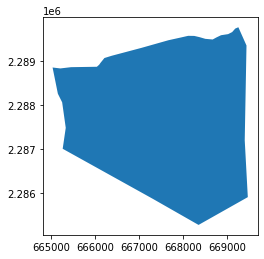

In [3]:
area_gdf = gpd.read_file('../../data/processed/walking_experience/test_area.geojson')
area_gdf.plot()

## Gather data

In [4]:
gdf_tmp = area_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

### Street network

In [9]:
_, nodes, edges = aup.graph_from_hippo(area_gdf, schema='osmnx',
                    edges_folder='edges_speed', nodes_folder='nodes')

In [10]:
print(edges.shape)
edges.head(2)

(7540, 19)


,,,osmid,oneway,lanes,name,highway,length,geometry,grade,grade_abs,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
u,v,key,,,,,,,,,,,,,,,,,,,
8810389307,8341878268,0,897534241,False,None,None,service,20.262,"LINESTRING (-103.38260 20.69726, -103.38255 20...",-0.049,0.049,None,None,None,None,None,None,None,None,3.369601,0.360790
1370726825,6393761118,0,829845577,True,2,Avenida Montevideo,tertiary,79.158,"LINESTRING (-103.38972 20.69600, -103.38954 20...",-0.013,0.013,None,None,None,None,None,None,None,None,3.822078,1.242643


In [11]:
print(nodes.shape)
nodes.head(2)

(3848, 4)


,x,y,street_count,geometry
osmid,,,,
28791285,-103.386953,20.674556,3,POINT (-103.38695 20.67456)
28791397,-103.387021,20.674199,3,POINT (-103.38702 20.67420)


<AxesSubplot:>

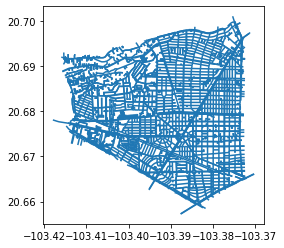

In [12]:
edges.plot()

### NDVI

In [15]:
query = f"SELECT * FROM raster_analysis.ndvi_analysis_hex WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\') AND res=11"
ndvi = aup.gdf_from_query(query, geometry_col='geometry')
print(ndvi.shape)
ndvi.head(4)

(5617, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8b49ab59adb3fff,"POLYGON ((-103.41224 20.67526, -103.41206 20.6...",11,0.209056,0.049667,0.222318,0.256545,0.147809,0.108736,-0.001315,Guadalajara
1,8b49ab59acb4fff,"POLYGON ((-103.41200 20.67769, -103.41182 20.6...",11,0.138349,0.031808,0.138421,0.172743,0.090207,0.082537,-0.000327,Guadalajara
2,8b49ab59ac9bfff,"POLYGON ((-103.41213 20.68089, -103.41196 20.6...",11,0.120932,0.022378,0.127444,0.136917,0.089804,0.047113,-0.000548,Guadalajara
3,8b49ab59acb6fff,"POLYGON ((-103.41152 20.67790, -103.41135 20.6...",11,0.161291,0.035995,0.164078,0.200824,0.106684,0.094139,-0.000772,Guadalajara


<AxesSubplot:>

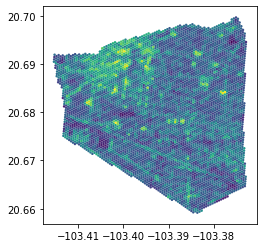

In [16]:
ndvi.plot('ndvi_mean')

### Estructura urbana - Frente de manzana - Marco Geoestadístico

In [18]:
query = f"SELECT * FROM censo_urbano.censo_fm_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
entorno = aup.gdf_from_query(query, geometry_col='geometry')
print(entorno.shape)
entorno.head(4)

(3973, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1403900015648002,14,039,0001,5648,002,05108,00004,2,San Bonifacio,...,3,1,1,3,3,3,1,1,11,0
1,1403900011043003,14,039,0001,1043,003,00180,00001,2,Huicholes,...,1,1,1,3,3,3,1,1,11,0
2,1403900011062021,14,039,0001,1062,021,03273,00002,1,Martín Casillas,...,3,1,1,3,3,3,1,1,11,0
3,141200001116A073,14,120,0001,116A,073,17710,00001,3,Paseo del Acantilado,...,3,3,3,3,3,3,1,1,11,0


### DENUE

### Censo